In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *

from matplotlib import rc
from matplotlib import pyplot as plt

plt.style.use("seaborn-poster")
rc('font', **{'family': 'Microsoft Yahei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

## 1. 准备因子历史数据
-----------------------

In [2]:
factor_name = 'ROE'
neutralized_styles = risk_styles + industry_styles
start_date = '2010-01-01'
end_date = '2019-02-01'
engine = SqlEngine(os.environ['DB_URI'])
universe_name = 'ashare_ex'
freq = '5b'

In [ ]:
universe = Universe(universe_name)
dates = makeSchedule(start_date, end_date, freq, calendar='china.sse')
factors = engine.fetch_factor_range(universe, factor_name, dates=dates)
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates)
dx_returns = engine.fetch_dx_return_range(universe, dates=dates, horizon=map_freq(freq))
total_data = pd.merge(factors, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, dx_returns, on=['trade_date', 'code'])
total_data.dropna(inplace=True)

## 2. 计算历史IC序列
----------------------

In [ ]:
neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data['ROE'].values,
                                 groups=total_data['trade_date'])
total_data['neutralized_factors'] = neutralized_factors

In [ ]:
ic_series = total_data.groupby('trade_date').apply(lambda x: np.corrcoef(x['neutralized_factors'], x['dx'])[0, 1])
ic_series.rolling(window=7).mean().plot(figsize=(14, 7))

## 3. 行业内IR计算
---------------------

In [95]:
industry_category = engine.fetch_industry_range(universe, dates=dates)
total_data = pd.merge(total_data, industry_category, on=['trade_date', 'code']).dropna()

In [96]:
industry_ic = total_data.groupby(['trade_date', 'industry']).apply(lambda x: np.corrcoef(x['neutralized_factors'], x['dx'])[0, 1])

D:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
D:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
D:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


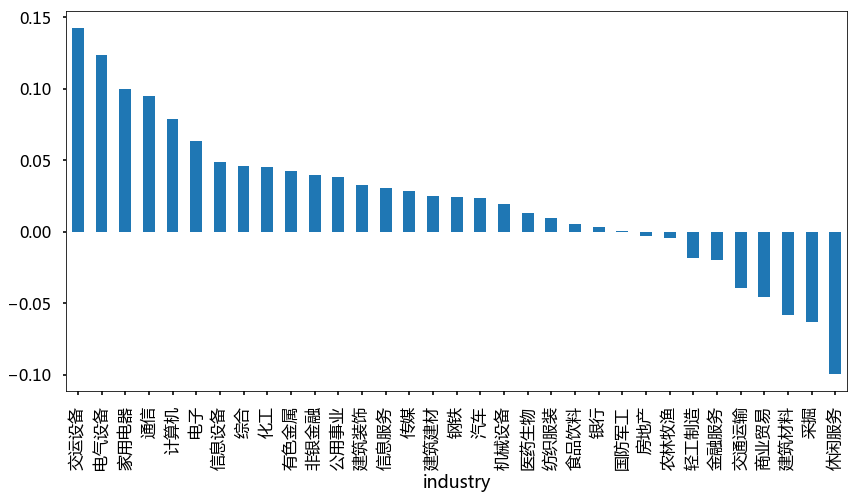

In [97]:
(industry_ic.groupby(level=1).mean() / industry_ic.groupby(level=1).std()).sort_values(ascending=False).plot(kind='bar', figsize=(14, 7))